# IAU projekt

> Rovnakým podieľom práce vypracovali: <br>
> Roman Bitarovský, Emma Macháčová

In [1]:
# pause

## Table of contents <a name="obsah"></a>
* [Zadanie](#zadanie)
    * [Slovníček](#slovnicek)
   
* [Data init (Fáza 1)](#dataInit)
* [Fáza 2](#faza2)
    * [2.1. Integrácia a čistenie dát](#2.1.)
        * [2.1.1. Replacing NaNs](#2.1.1.)
            * [2.1.1.1. Replacing NaNs - Method 1: Drop nans](#2.1.1.a)
            * [2.1.1.2. Replacing NaNs - Method 2: Replace with Mean](#2.1.1.b)
            * [2.1.1.3. Replacing NaNs - Method 3: Replace with Median](#2.1.1.c)
            * [2.1.1.4. Replacing NaNs - Method 4: Replace with kNN](#2.1.1.d)
        * [2.1.2. Deleting Outliers Values](#2.1.2.)
    * [2.2. Realizácia predspracovania dát](#2.2.)  
        * [2.2.1. Transforovanie a škálovanie dát](#2.2.1.)
        * [2.2.2. Rozdelenie dát](#2.2.2.)
        * [2.2.3. Zhodnotenie ](#2.2.3.)
    * [2.3. Výber atribútov pre strojové učenie](#2.3.)  
        * [2.3.1. Variance Threshold ](#2.3.1.)
        * [2.3.2. SelectKBest](#2.3.2.)
        * [2.3.3 SelectPercentile](#2.3.3.)
        * [2.3.4. Záver výberov](#2.3.4.)
    * [2.4. Replikovateľnosť predspracovania](#2.4.)  
        * [2.4.1. Code improvements](#2.4.1.)
        * [2.4.2. Pipeline](#2.4.2.)

# Zadanie <a name="zadanie"></a>
Znečistenie ovzdušia spôsobuje vážne dýchacie a srdcové ochorenia, ktoré môžu byť smrteľné. Najčastejšie sú postihnuté deti, čo vedie k zápalu pľúc a problémom s dýchaním vrátane astmy. Kyslé dažde, ničenie ozónovej vrstvy a globálne otepľovanie sú niektoré z nepriaznivých dôsledkov. Dátová sada pre Vás (World's Air Pollution: Real-time Air Quality Index https://waqi.info/) predstavuje záznamy jednotlivých meraní kvality ovzdušia ako kombinácia mnohých faktorov bez časovej následnosti. V záznamoch je závislá premenná s menom “warning” indikujúca alarmujúci stav kvality ovzdušia. Vo veľkých mestách ako napr. Peking (angl. Beijing, hlavné mesto Číny s viac ako 21 miliónov ľudí) sa pri varovaní spustí opatrenie ako obmedzenie pohybov áut a ľudí v meste alebo umelý dážď až pokiaľ kvalita vzduchu sa nevráti do normu.

* Úlohou je predikovať závislé hodnoty premennej “warning” pomocou metód strojového učenia.
* Pritom sa treba vysporiadať s viacerými problémami, ktoré sa v dátach nachádzajú ako formáty dát, chýbajúce, vychýlené hodnoty a pod.

## Slovníček  <a name="slovnicek"></a>
<details>
    <summary>Zobraziť</summary>
    
    PM2.5 - Particulate Matter (µg/m3) 
    PM10 - Particulate Matter (µg/m3) 
    NOx - Nitrogen Oxides (µg/m3)
    NO2 - Nitrogen Dioxide (µg/m3)
    SO2 - Sulfur Dioxide  (µg/m3)
    CO - Carbon Monoxide emissions  (µg/m3)
    CO2 - Carbon Dioxide  (µg/m3)
    PAHs - Polycyclic Aromatic Hydrocarbons  (µg/m3)
    NH3 - Ammonia trace  (µg/m3)
    Pb - Lead  (µg/m3)
    TEMP - Temperature (degree Celsius)
    DEWP - Dew point temperature (degree Celsius)
    PRES - Pressure (hPa, <100, 1050>)
    RAIN - Rain (mm)
    WSPM - Wind Speed (m/s)
    WD - Wind Direction
    VOC - Volatile Organic Compounds
    CFCs - Chlorofluorocarbons
    C2H3NO5 - Peroxyacetyl nitrate
    H2CO - Plywood emit formaldehyde
    GSTM1 - Glutathione-S transferase M1
    1-OHP - 1-hydroxypyrene
    2-OHF - 2-hydroxyfluorene
    2-OHNa - 2-hydroxynaphthalene
    N2 - Nitrogen
    O2 - Oxygen
    O3 - Ozone
    Ar - Argon
    Ne - Neon
    CH4 - Methane
    He - Helium
    Kr - Krypton
    I2 - Iodine
    H2 - Hydrogen
    Xe - Xenon
</details>

# Data init <a name="dataInit"></a>

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.stats as sm_stats
from scipy.stats import mannwhitneyu
from scipy.stats import f_oneway

import datetime
import re
import category_encoders as ce
from sklearn.impute import SimpleImputer, KNNImputer
from numpy import percentile

from sklearn.preprocessing import PowerTransformer, QuantileTransformer

from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectPercentile, SelectFromModel
from sklearn.feature_selection import mutual_info_regression, chi2, f_regression, f_classif
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [3]:
labor_measurements = pd.read_csv('../081/measurements.csv', sep='\t')
labor_stations = pd.read_csv('../081/stations.csv', sep='\t')

Úprava dát rovnaká ako vo fáze 1, hlavne teda merge tabuliek.

In [4]:
labor_stations["QoS"].replace({"acceptable": "accep", "maitennce": "maintenance"}, inplace=True)
labor_stations['revision'] = pd.to_datetime(labor_stations['revision'], utc=False)

labor_measurements.replace('', np.nan, inplace=True)
labor_stations.replace('', np.nan, inplace=True)

labor_measurements = labor_measurements.drop_duplicates()
labor_stations = labor_stations.drop_duplicates()

# merge preprocesing
labor_stations = labor_stations.drop(columns=['revision', 'code', 'QoS'])
labor_stations = labor_stations.drop_duplicates()

# Table merge
df = pd.merge(labor_measurements, labor_stations, how='inner', left_on=['latitude', 'longitude'], right_on=['latitude', 'longitude'])

df = df.drop(columns=['latitude', 'longitude'])
df = df[['location', 'warning', 'TEMP', 'PRES', 'PM2.5', 'NOx', 'PM10', 'C2H3NO5', 'CH4', 'Pb', 'NH3', 'SO2', 'O3', 'CO', 'PAHs', 'H2CO', 'CFCs']]

df.head()

,location,warning,TEMP,PRES,PM2.5,NOx,PM10,C2H3NO5,CH4,Pb,NH3,SO2,O3,CO,PAHs,H2CO,CFCs
0,America/Los_Angeles,0.0,20.05101,1139.12673,8.47714,9.21522,9.38738,1.51791,7.84989,59.51096,10.43604,5.81201,7.77502,9.69678,8.62090,47.64810,74.87342
1,America/Los_Angeles,1.0,21.55701,1115.19699,7.36880,9.66741,8.19826,0.64236,8.48027,54.03980,9.62838,7.97135,9.72566,5.83821,8.28391,64.99154,63.42154
2,America/Los_Angeles,1.0,3.06998,1086.02547,9.81855,9.66138,6.16989,0.23616,8.49506,47.32216,6.38848,6.14333,9.73098,7.37730,5.98279,43.12537,71.61779
3,America/Los_Angeles,1.0,10.04558,1168.02340,8.76470,10.27526,7.10130,0.17080,7.35744,48.49527,8.11869,6.74522,9.63330,4.89810,8.76285,43.67037,64.64020
4,America/Los_Angeles,1.0,24.88676,1061.95581,6.76710,9.95663,8.35517,0.75765,6.98671,52.91472,8.87397,9.24788,8.40595,10.82485,7.88543,40.39068,70.46390


Prekodovanie textu lokácie na číselné hodnoty pre umožnenie spracovania ML. 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11939 entries, 0 to 11938
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   location  11939 non-null  object 
 1   warning   11891 non-null  float64
 2   TEMP      11891 non-null  float64
 3   PRES      11939 non-null  float64
 4   PM2.5     11891 non-null  float64
 5   NOx       11891 non-null  float64
 6   PM10      11891 non-null  float64
 7   C2H3NO5   11891 non-null  float64
 8   CH4       11891 non-null  float64
 9   Pb        11891 non-null  float64
 10  NH3       11891 non-null  float64
 11  SO2       11891 non-null  float64
 12  O3        11891 non-null  float64
 13  CO        11891 non-null  float64
 14  PAHs      11891 non-null  float64
 15  H2CO      11891 non-null  float64
 16  CFCs      11891 non-null  float64
dtypes: float64(16), object(1)
memory usage: 1.6+ MB


# Fáza 2 Predspracovanie údajov <a name="faza2"></a> 
 
# 2.1 Integrácia a čistenie dát (5b) <a name="2.1."></a>
Transformujte dáta na vhodný formát pre strojové učenie t.j. jedno pozorovanie musí byť opísané jedným riadkom a každý atribút musí byť v numerickom formáte. 
* Pri riešení chýbajúcich hodnôt (missing values) vyskúšajte rôzne stratégie ako napr.
    * odstránenie pozorovaní s chýbajúcimi údajmi
    * nahradenie chýbajúcej hodnoty mediánom, priemerom, pomerom (ku korelovanému atribútu), alebo pomocou lineárnej regresie resp. kNN
* Podobne postupujte aj pri riešení vychýlených hodnôt (outlier detection):
    * odstránenie vychýlených (odľahlých) pozorovaní
    * nahradenie vychýlenej hodnoty hraničnými hodnotami rozdelenia (5% resp. 95%)
  
<b>Go to:</b>  
* [Naspäť na Obsah](#obsah)
* [Replacing NaNs - Method 1: Drop nans](#2.1.1.a)
* [Replacing NaNs - Method 2: Replace with Mean](#2.1.1.b)
* [Replacing NaNs - Method 3: Replace with Median](#2.1.1.c)
* [Replacing NaNs - Method 4: Replace with kNN](#2.1.1.d)
* [Deleting Outliers Values](#2.1.2.)

In [6]:
df_not_changed = df.copy() # zachovanie originálneho df pre potencionálne pororvnávanie

Prekódovanie stĺpca location na číselné hodnoty pre možnosť spracovania pomocou ML.

In [7]:
ce_ordinal = ce.OrdinalEncoder(cols=['location'])
df_ml = ce_ordinal.fit_transform(df)
df_ml

,location,warning,TEMP,PRES,PM2.5,NOx,PM10,C2H3NO5,CH4,Pb,NH3,SO2,O3,CO,PAHs,H2CO,CFCs
0,1,0.0,20.05101,1139.12673,8.47714,9.21522,9.38738,1.51791,7.84989,59.51096,10.43604,5.81201,7.77502,9.69678,8.62090,47.64810,74.87342
1,1,1.0,21.55701,1115.19699,7.36880,9.66741,8.19826,0.64236,8.48027,54.03980,9.62838,7.97135,9.72566,5.83821,8.28391,64.99154,63.42154
2,1,1.0,3.06998,1086.02547,9.81855,9.66138,6.16989,0.23616,8.49506,47.32216,6.38848,6.14333,9.73098,7.37730,5.98279,43.12537,71.61779
3,1,1.0,10.04558,1168.02340,8.76470,10.27526,7.10130,0.17080,7.35744,48.49527,8.11869,6.74522,9.63330,4.89810,8.76285,43.67037,64.64020
4,1,1.0,24.88676,1061.95581,6.76710,9.95663,8.35517,0.75765,6.98671,52.91472,8.87397,9.24788,8.40595,10.82485,7.88543,40.39068,70.46390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11934,10,1.0,-4.79197,1130.15144,10.03862,7.85019,2.61045,0.16818,7.93426,42.37355,6.51674,7.03170,4.37153,9.76505,7.85202,32.10196,81.64000
11935,10,0.0,7.30387,1191.87826,9.53663,9.61895,8.89174,0.94656,7.79162,39.72329,6.95733,10.58370,7.47375,12.15236,8.80525,73.44011,63.83947
11936,10,1.0,16.43794,1080.62899,8.98586,8.92907,9.21569,1.45297,8.30146,54.14633,7.86831,7.67169,12.78567,7.00978,8.29119,60.99687,77.04895
11937,10,0.0,6.07748,1078.80233,11.18488,6.87410,7.21010,0.31668,8.18607,NaN,7.83408,9.00897,8.16025,11.34004,8.39922,53.89033,87.39587


## 2.1.1. Replacing NaNs <a name="2.1.1."></a>

Funkcia na handlovanie NaN podľa vybranej stratégie (kNN, mean, median alebo drop). Funkcia aj ukáže porovnanie rozdielu korelácií danej stratégie handlovania NaNs s pôvodným df.

In [8]:
def replaceNaN(df_original, strategy):
    df = df_original.copy()

    na_cols = df.columns[df.isnull().any()].tolist()
    
    if strategy == 'kNN':
        imp_strategy = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

    elif strategy == 'mean' or strategy == 'median':    
        imp_strategy = SimpleImputer(missing_values=np.nan, strategy=strategy)
        
    elif strategy == 'drop_na':
        df = df.dropna()
        
    if strategy != 'drop_na':
        for col in na_cols:
            df[col] = imp_strategy.fit_transform(df[[col]])
        
    print(df.isnull().sum())
    
    fig, ax = plt.subplots(figsize=(16,8))
    corr_diff = df.corr() - df_original.corr()
    sns.heatmap(corr_diff[abs(corr_diff) > 0.000099], ax=ax, annot=True, fmt=".4f")
    
    return df

### Replacing NaNs - Method 1: Drop nans <a name="2.1.1.a"></a>

location    0
warning     0
TEMP        0
PRES        0
PM2.5       0
NOx         0
PM10        0
C2H3NO5     0
CH4         0
Pb          0
NH3         0
SO2         0
O3          0
CO          0
PAHs        0
H2CO        0
CFCs        0
dtype: int64


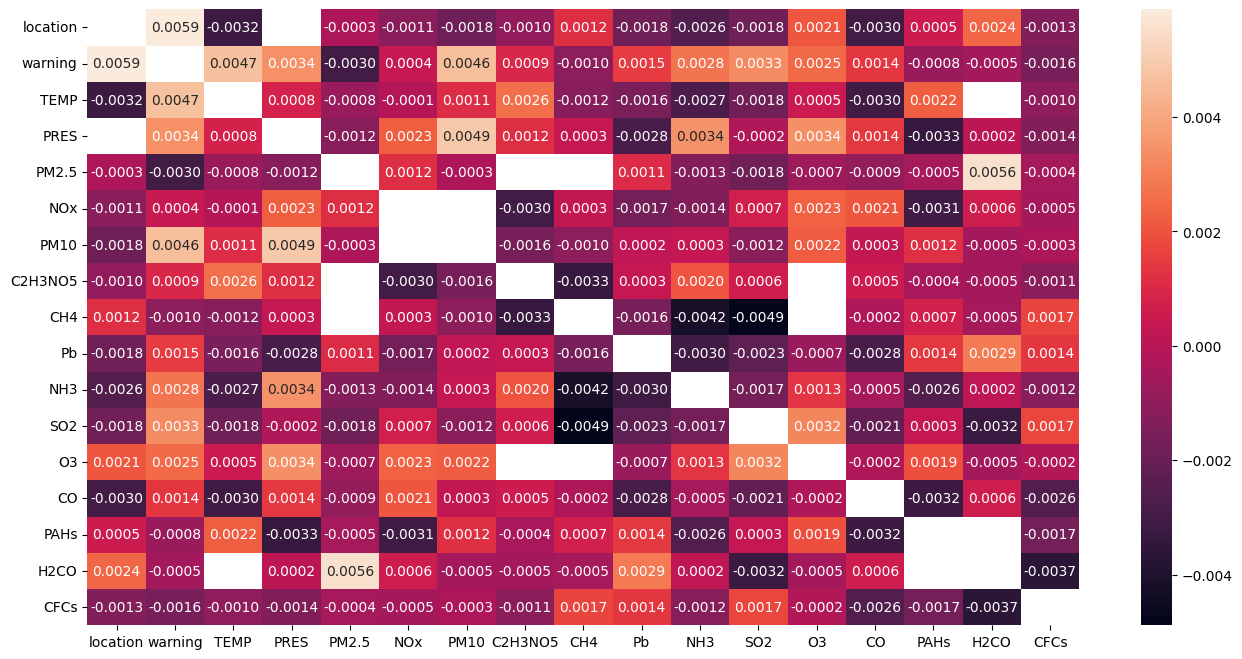

In [9]:
df_ml_dropedNa = replaceNaN(df_ml, 'drop_na')

### Replacing NaNs - Method 2: Replace with Mean <a name="2.1.1.b"></a>

location    0
warning     0
TEMP        0
PRES        0
PM2.5       0
NOx         0
PM10        0
C2H3NO5     0
CH4         0
Pb          0
NH3         0
SO2         0
O3          0
CO          0
PAHs        0
H2CO        0
CFCs        0
dtype: int64


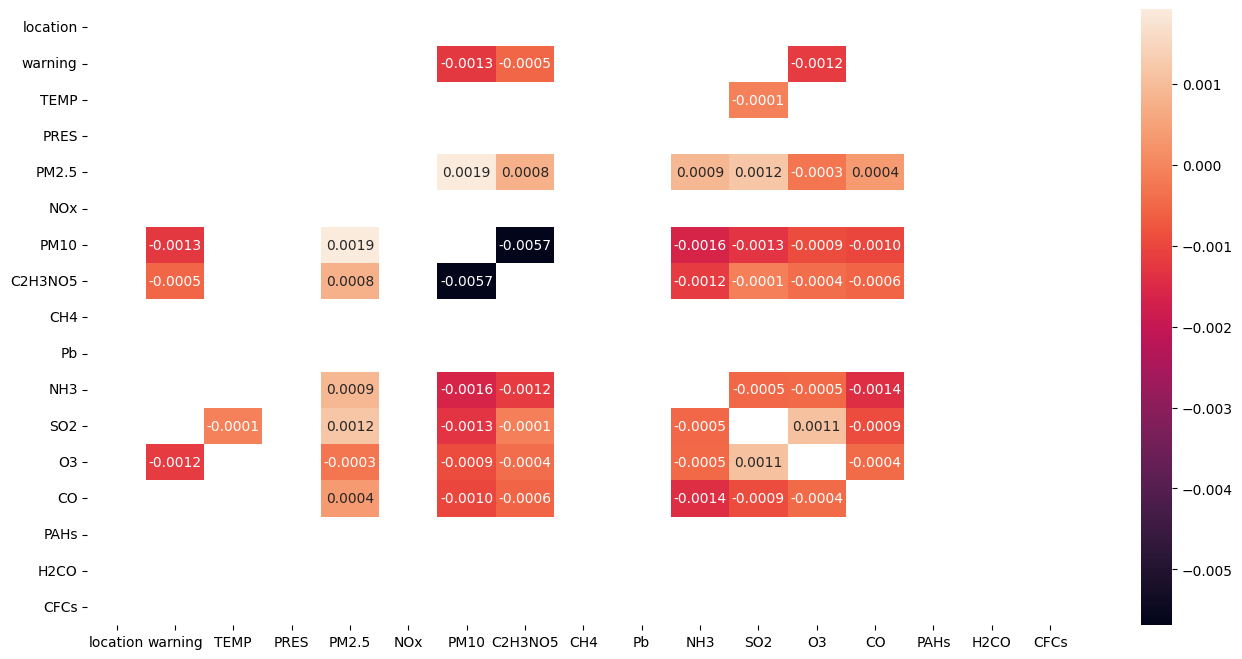

In [10]:
df_ml_na_mean = replaceNaN(df_ml, 'mean')

### Replacing NaNs - Method 3: Replace with Median <a name="2.1.1.c"></a>

location    0
warning     0
TEMP        0
PRES        0
PM2.5       0
NOx         0
PM10        0
C2H3NO5     0
CH4         0
Pb          0
NH3         0
SO2         0
O3          0
CO          0
PAHs        0
H2CO        0
CFCs        0
dtype: int64


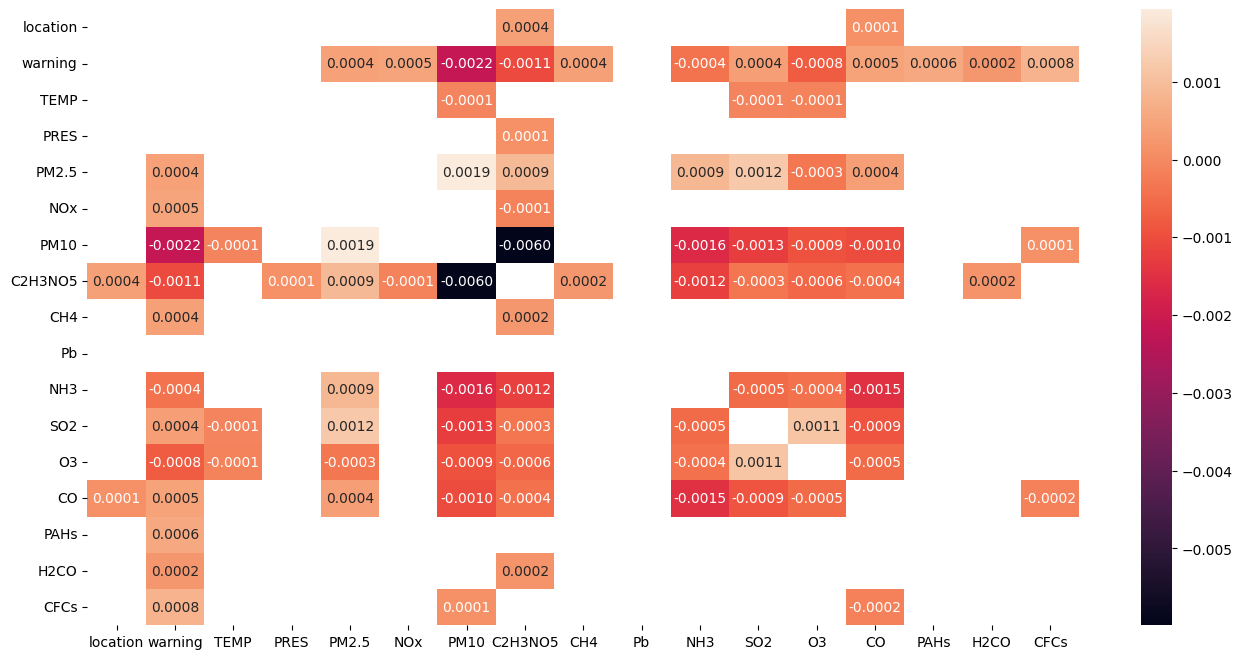

In [11]:
df_ml_na_median = replaceNaN(df_ml, 'median')

### Replacing NaNs - Method 4: Replace with kNN <a name="2.1.1.d"></a>

location    0
warning     0
TEMP        0
PRES        0
PM2.5       0
NOx         0
PM10        0
C2H3NO5     0
CH4         0
Pb          0
NH3         0
SO2         0
O3          0
CO          0
PAHs        0
H2CO        0
CFCs        0
dtype: int64


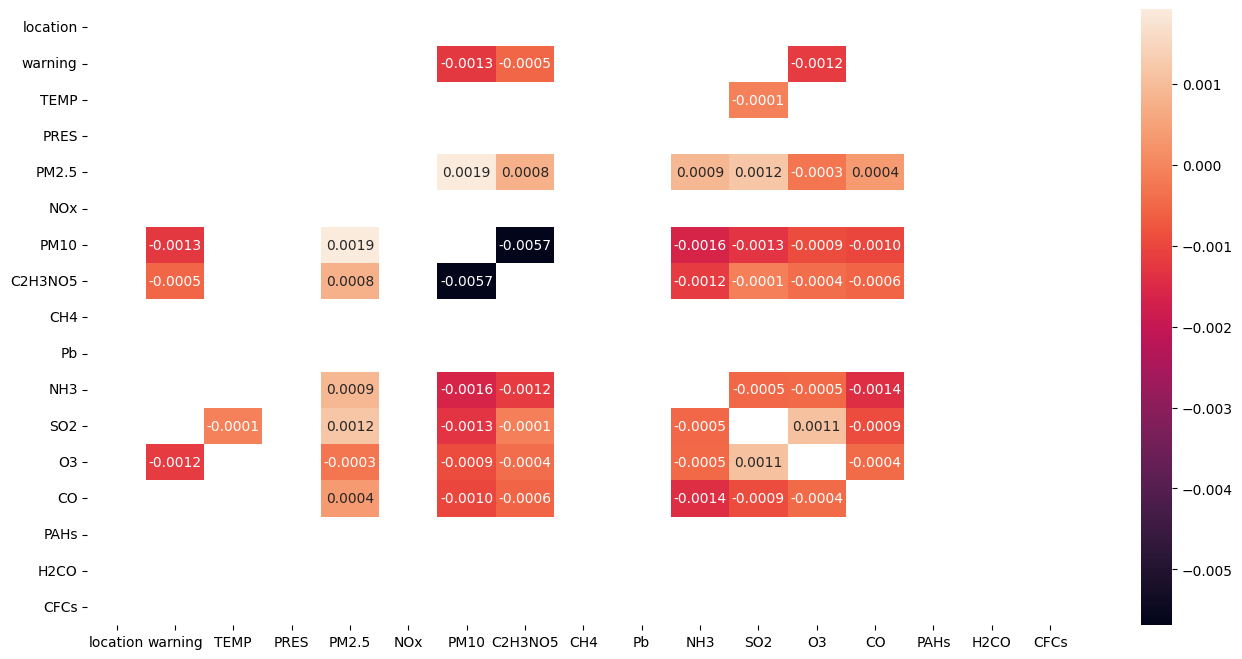

In [12]:
df_ml_na_knn = replaceNaN(df_ml, 'kNN')

Pre ďaľšiu prácu s dátami sme si vybrali možnosť nahradenia NaNs pomocou kNN.

## 2.1.2. Deleting Outlier Values <a name="2.1.2."></a>

Prvotné zobrazenie outlier values pomocou grafu pre každý atribút data setu.

location       AxesSubplot(0.125,0.786098;0.227941x0.0939024)
warning     AxesSubplot(0.398529,0.786098;0.227941x0.0939024)
TEMP        AxesSubplot(0.672059,0.786098;0.227941x0.0939024)
PRES           AxesSubplot(0.125,0.673415;0.227941x0.0939024)
PM2.5       AxesSubplot(0.398529,0.673415;0.227941x0.0939024)
NOx         AxesSubplot(0.672059,0.673415;0.227941x0.0939024)
PM10           AxesSubplot(0.125,0.560732;0.227941x0.0939024)
C2H3NO5     AxesSubplot(0.398529,0.560732;0.227941x0.0939024)
CH4         AxesSubplot(0.672059,0.560732;0.227941x0.0939024)
Pb             AxesSubplot(0.125,0.448049;0.227941x0.0939024)
NH3         AxesSubplot(0.398529,0.448049;0.227941x0.0939024)
SO2         AxesSubplot(0.672059,0.448049;0.227941x0.0939024)
O3             AxesSubplot(0.125,0.335366;0.227941x0.0939024)
CO          AxesSubplot(0.398529,0.335366;0.227941x0.0939024)
PAHs        AxesSubplot(0.672059,0.335366;0.227941x0.0939024)
H2CO           AxesSubplot(0.125,0.222683;0.227941x0.0939024)
CFCs    

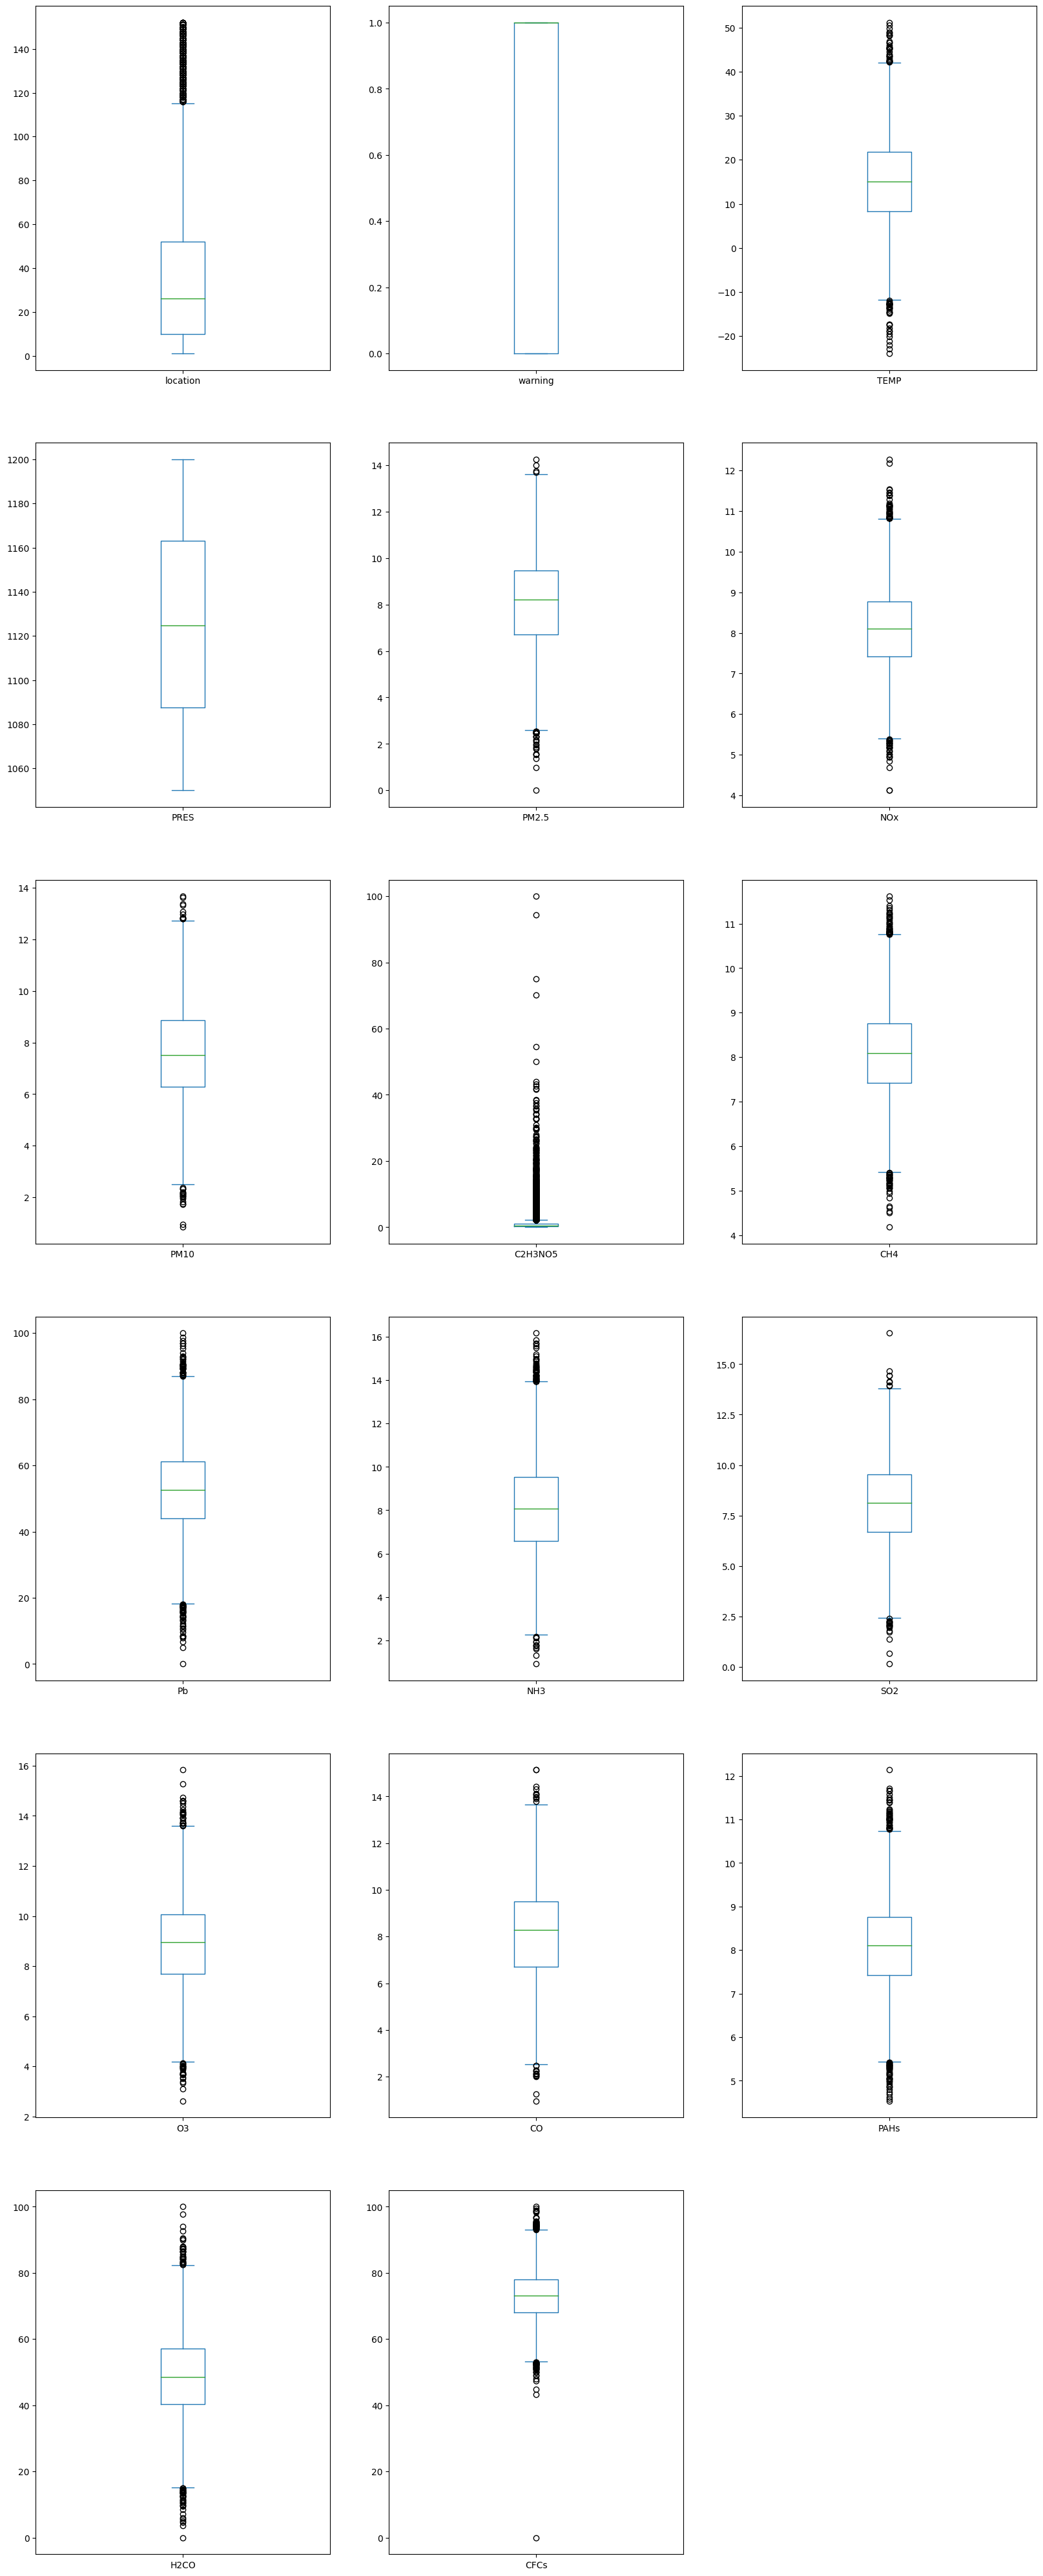

In [13]:
df_ml_na_knn.plot(kind='box', subplots=True, layout=(7, 3), sharex=False, sharey=False, figsize=(20, 60))

In [14]:
outliers_limit_low = 0
outliers_limit_up = 0
def identify_outliers(df):
    
    Qa = df.quantile(0.05)
    Qb = df.quantile(0.95)
    IQR = Qb - Qa
    
    global outliers_limit_low
    outliers_limit_low = (Qa - 1.5 * IQR)
    global outliers_limit_up 
    outliers_limit_up = (Qb + 1.5 * IQR)
    
    return ((df < outliers_limit_low) | (df > outliers_limit_up)).sum()

In [15]:
identify_outliers(df_ml_na_knn)

location      0
warning       0
TEMP          0
PRES          0
PM2.5         0
NOx           0
PM10          0
C2H3NO5     156
CH4           0
Pb            0
NH3           0
SO2           0
O3            0
CO            0
PAHs          0
H2CO          0
CFCs          1
dtype: int64

In [16]:
outliers_limit_low

location   -169.500000
warning      -1.500000
TEMP        -50.430883
PRES        854.703742
PM2.5        -4.489507
NOx           1.560324
PM10         -4.331160
C2H3NO5      -7.407493
CH4           1.444322
Pb          -31.439569
NH3          -5.613780
SO2          -4.931287
O3           -2.674604
CO           -4.283335
PAHs          1.526239
H2CO        -34.562272
CFCs         24.611047
dtype: float64

In [17]:
outliers_limit_up

location     290.500000
warning        2.500000
TEMP          80.218306
PRES        1395.596283
PM2.5         20.336645
NOx           14.634593
PM10          19.669400
C2H3NO5       12.691027
CH4           14.707791
Pb           136.591623
NH3           21.987593
SO2           20.960774
O3            20.094848
CO            20.022425
PAHs          14.676527
H2CO         131.515877
CFCs         121.715562
dtype: float64

Rozhodli sme sa nahradiť outliers hraničnými hodnotami.

In [18]:
def replace_outliers(df_original):
    df = df_original.copy()
    
    for col in df.columns:  
        
        if col not in ['location', 'warning']:

            q05 = percentile(df[col], 5)
            q95 = percentile(df[col], 95)

            df[col] = np.where(df[col] < q05, q05, df[col])
            df[col] = np.where(df[col] > q95, q95, df[col])
            
    return df

In [19]:
df_ml_na_knn_notOutliers = replace_outliers(df_ml_na_knn)

In [20]:
identify_outliers(df_ml_na_knn_notOutliers)

location    0
warning     0
TEMP        0
PRES        0
PM2.5       0
NOx         0
PM10        0
C2H3NO5     0
CH4         0
Pb          0
NH3         0
SO2         0
O3          0
CO          0
PAHs        0
H2CO        0
CFCs        0
dtype: int64

Text(0.5, 1.0, 'Po odstránení outlierov')

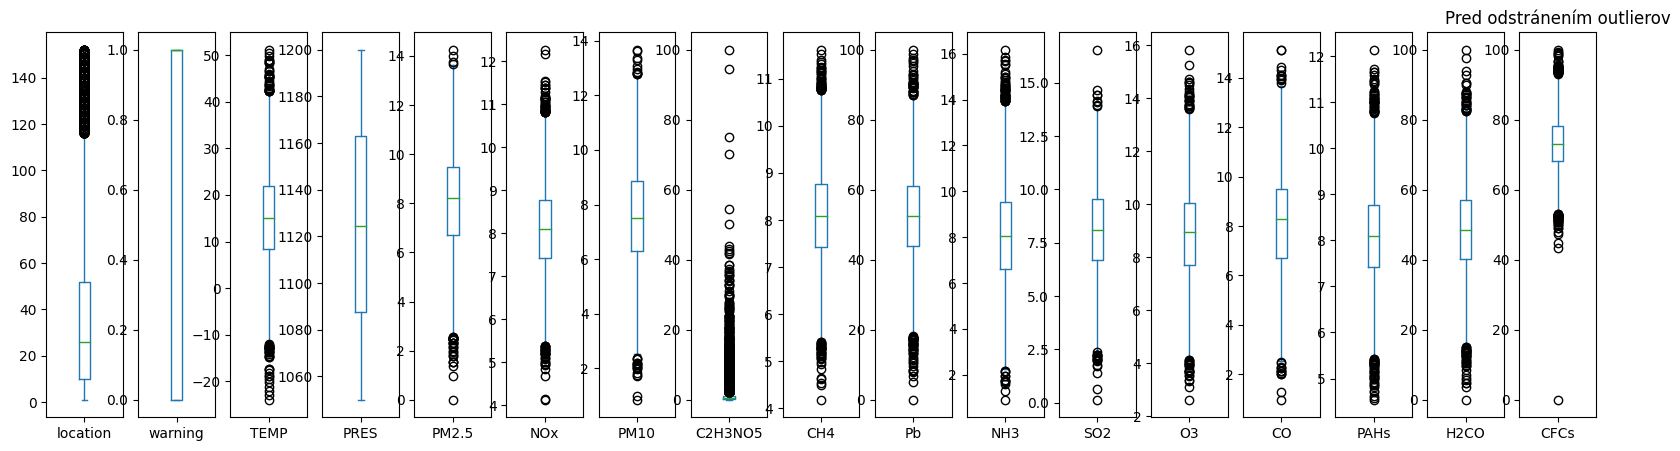

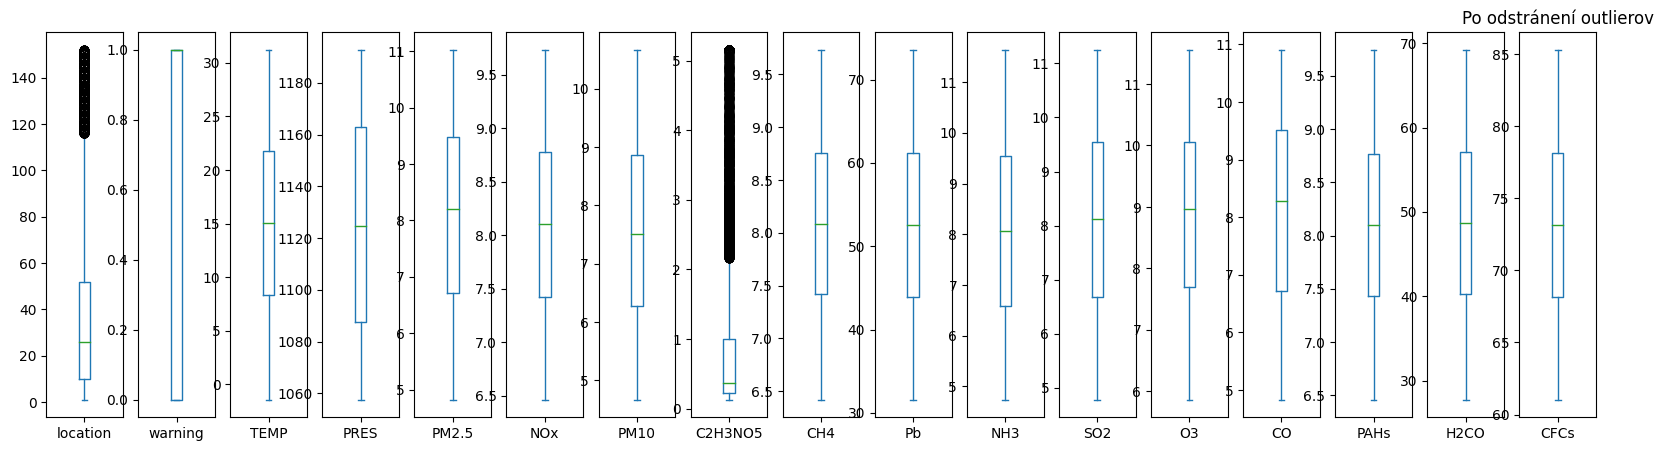

In [21]:
df_ml_na_knn.plot(kind='box', subplots=True, layout=(1, 17), sharex=False, sharey=False, figsize=(20, 5))
plt.title('Pred odstránením outlierov')
df_ml_na_knn_notOutliers.plot(kind='box', subplots=True, layout=(1, 17), sharex=False, sharey=False, figsize=(20, 5))
plt.title('Po odstránení outlierov')

Aribúty location a warning sme samozrejme nenahradzovali nakoľko sú kategorické a jednoznačne určené.

# 2.2. Realizácia predspracovania dát (5b). <a name="2.2."></a>
* Transformované dáta pre strojové učenie si rozdeľuje na trénovaciu a testovaciu množinu podľa vami preddefinovaným pomerom. Naďalej pracujte len s trénovacím datasetom.
* Transformujte atribútov dát pre strojové učenie podľa dostupných techník (minimálne 2 techniky) ako scaling, transformers a ďalšie.
* Zdôvodnite Vašu voľby/rozhodnutie pre realizáciu (t.j. zdokumentovanie)

<b>Go to:</b>  
* [Naspäť na Obsah](#obsah)
* [Transforovanie a škálovanie dát](#2.2.1.)
* [Rozdelenie dát](#2.2.2.)
* [Zhodnotenie ](#2.2.3.)

In [22]:
df = df_ml_na_knn_notOutliers.copy()

## 2.2.1. Transforovanie a škálovanie dát <a name="2.2.1."></a>

/var/folders/tj/_nl_hwzj02n8b9pt35wr92zw0000gn/T/ipykernel_77665/2219516243.py:28: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(16, 2, num+1)
/var/folders/tj/_nl_hwzj02n8b9pt35wr92zw0000gn/T/ipykernel_77665/2219516243.py:28: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(16, 2, num+1)
/var/folders/tj/_nl_hwzj02n8b9pt35wr92zw0000gn/T/ipykernel_77665/2219516243.py:28: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(16, 2, num+1)
/var/folders/tj/_nl_hwzj02n8b9pt35wr92zw0000gn/T/ipykernel_77665/2219516243.py:28: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is de

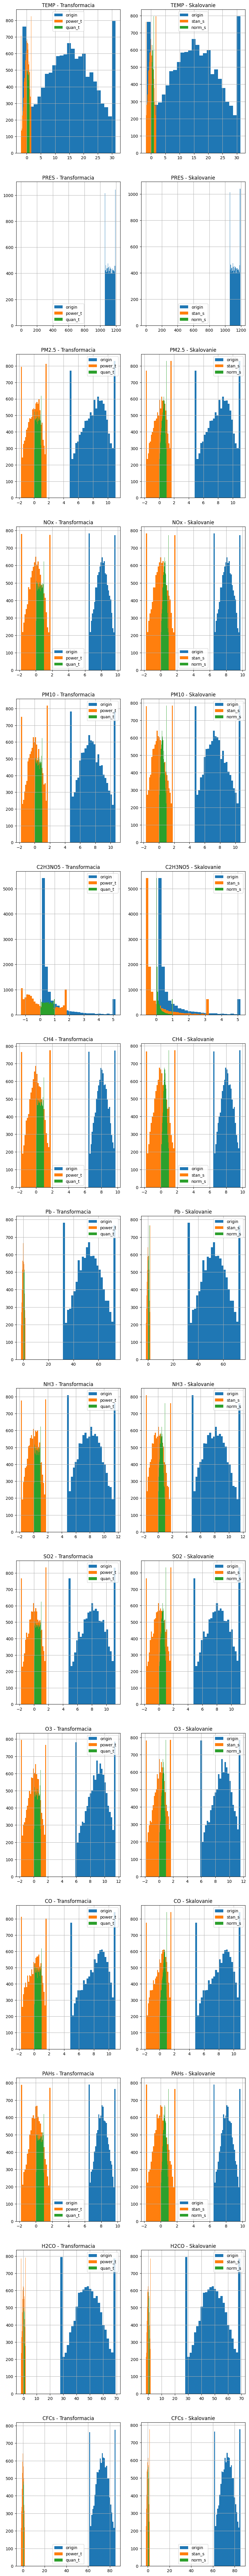

In [23]:
power = PowerTransformer(method='yeo-johnson', standardize=True)
quan = QuantileTransformer(n_quantiles=20, random_state=0)
stan_s = StandardScaler()
norm_s = MinMaxScaler()

m_col = [
    'TEMP', 'TEMP', 
    'PRES', 'PRES',
    'PM2.5', 'PM2.5', 
    'NOx', 'NOx', 
    'PM10','PM10', 
    'C2H3NO5', 'C2H3NO5', 
    'CH4', 'CH4',
    'Pb', 'Pb',          
    'NH3', 'NH3', 
    'SO2', 'SO2',
    'O3', 'O3',
    'CO', 'CO',
    'PAHs', 'PAHs', 
    'H2CO', 'H2CO',
    'CFCs', 'CFCs'
]

fig, axs = plt.subplots(2, 2, figsize=(10,120))

for num, col_name in enumerate(m_col):
    
    plt.subplot(16, 2, num+1)
    plt.hist(df[col_name], bins=25)
    
    if num % 2 == 0:
        plt.title(col_name + ' - Transformacia')
        pow_trans = power.fit_transform(df[[col_name]])
        plt.hist(pow_trans, bins=25)
        q_trans = quan.fit_transform(df[[col_name]])

        plt.hist(q_trans, bins=25)
        plt.grid()
        plt.legend(['origin', 'power_t', 'quan_t'])

    
    else:
        plt.title(col_name + ' - Skalovanie')
        s_scaled = stan_s.fit_transform(df[[col_name]])
        plt.hist(s_scaled, bins=25)
        n_scaled = norm_s.fit_transform(df[[col_name]])

        plt.hist(n_scaled, bins=25)
        plt.grid()
        plt.legend(['origin', 'stan_s', 'norm_s'])

yeo-johnson sme vybrali preto lebo Box-cox nepodporuje transformáciu záporných hodnôt

In [24]:
# @TODO napísať vyhodnotenie pre tieto obrázky

## 2.2.2. Rozdelenie dát <a name="2.2.2."></a>

Dataset rozdelíme v pomere:
* 1/3 pre testovaciu množinu 
* 2/3 pre trénovaciu množinu 
pre indikátor (y) a pre ostatné atribúty (X).

In [25]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['warning'], axis=1), df['warning'], test_size=0.33)

## 2.2.3. Zhodnotenie <a name="2.2.3."></a>

@TODO

# 2.3. Výber atribútov pre strojové učenie (5b) <a name="2.3."></a>
* Zistite ktoré atribúty (features) vo vašich dátach pre strojové učenie sú informatívne k atribútu “warning”. Zoradíte tie atribúty v poradí podľa dôležitosti. 
* Zdôvodnite Vašu voľby/rozhodnutie pre realizáciu (t.j. zdokumentovanie)

<b>Go to:</b>  
* [Naspäť na Obsah](#obsah)
* [Variance Threshold ](#2.3.1.)
* [SelectKBest](#2.3.2.)
* [SelectPercentile](#2.3.3.)
* [Záver výberov](#2.3.4.)

## 2.3.1. Variance Threshold <a name="2.3.1."></a>

In [26]:
X = X_train.copy()
y = y_train.copy()
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
colsVT = sel.fit_transform(X)

In [27]:
print('Pôvodný počet stĺpcov: ', X.shape[1])
if (X.shape[1] == colsVT[0].size):
    print('Všetky dáta sú užitočné')
elif (colsVT[0].size < X.shape[1]):
    print('Máme aj neužitočné dáta')

Pôvodný počet stĺpcov:  16
Všetky dáta sú užitočné


Teraz si vytvoríme funkciu pre určovanie dôležitosti atribútov na základe SelectKBest alebo SelectPercentile.

In [28]:
def orderColumns(X, y, selectionType, selectionTypeCategory):
    
    if (selectionTypeCategory == 'SelectKBest'):
        selector = SelectKBest(selectionType, k ='all')
    
    elif (selectionTypeCategory == 'SelectPercentile'):
        selector = SelectPercentile(selectionType, percentile=100)
    
    X_selected = selector.fit_transform(X, y)
    
    scores = selector.scores_
    
    col_names = X.columns[selector.get_support()]
    
    indices = []
    
    for _, x in sorted(zip(scores, col_names), reverse=True):
        indices.append(x)
    
    
    return indices

In [29]:
list_of_list = []

## 2.3.2. SelectKBest <a name="2.3.2."></a>

In [30]:
orders_funcs_list = [mutual_info_regression, f_regression]

In [31]:
for i in orders_funcs_list:
    temp = orderColumns(X, y, i, 'SelectKBest')
    list_of_list.append(temp)
    print(temp)

['O3', 'PM10', 'C2H3NO5', 'NH3', 'PM2.5', 'CH4', 'CO', 'H2CO', 'location', 'PRES', 'Pb', 'SO2', 'TEMP', 'PAHs', 'NOx', 'CFCs']
['O3', 'PM10', 'C2H3NO5', 'CO', 'PM2.5', 'Pb', 'NH3', 'TEMP', 'H2CO', 'CFCs', 'PAHs', 'location', 'SO2', 'CH4', 'PRES', 'NOx']


## 2.3.3 SelectPercentile <a name="2.3.3."></a>

In [32]:
orders_funcs_list = [f_classif, f_regression]

In [33]:
for i in orders_funcs_list:
    temp = orderColumns(X, y, i, 'SelectPercentile')
    list_of_list.append(temp)
    print(temp)

['O3', 'PM10', 'C2H3NO5', 'CO', 'PM2.5', 'PAHs', 'SO2', 'Pb', 'NH3', 'TEMP', 'location', 'CFCs', 'H2CO', 'PRES', 'CH4', 'NOx']
['O3', 'PM10', 'C2H3NO5', 'CO', 'PM2.5', 'Pb', 'NH3', 'TEMP', 'H2CO', 'CFCs', 'PAHs', 'location', 'SO2', 'CH4', 'PRES', 'NOx']


### 2.3.4. Záver výberov <a name="2.3.4."></a>

In [34]:
def orderLists(X, list_of_list):
    
    x_columns = X.columns
    x_weights = []
    
    for i in range(len(x_columns)):
        x_weights.append(i)
    
    for lst in list_of_list:
        for i in range(len(x_columns)):
            x_weights[i] += lst.index(x_columns[i])  
            
    map_of_cols = []
    for _, q in sorted(zip(x_weights, x_columns)):
        map_of_cols.append(q)
    
    return map_of_cols 

#### Záver výberu atribútov pre strojové učenie

Na základe výsledkov rôznych zoradení sme zoradenie spriemerovali.

In [35]:
orderLists(X, list_of_list)

['PM10',
 'O3',
 'C2H3NO5',
 'PM2.5',
 'CO',
 'NH3',
 'Pb',
 'TEMP',
 'location',
 'H2CO',
 'PAHs',
 'SO2',
 'CH4',
 'PRES',
 'CFCs',
 'NOx']

# 2.4. Replikovateľnosť predspracovania (5b) <a name="2.4."></a>
* Upravte váš kód realizujúci predspracovanie trénovacej množiny tak, aby ho bolo možné bez ďalších úprav znovupoužiť na predspracovanie testovacej množiny (pomocou funkcie/í)
* Očakáva sa aj využitie možnosti sklearn.pipeline

<b>Go to:</b>  
* [Naspäť na Obsah](#obsah)
* [Code improvements](#2.4.1.)
* [Pipeline](#2.4.2.)

## 2.4.1. Code improvements <a name="2.4.1."></a>

### Utils

In [36]:
def count_columns(df):
    return df.columns[df.isnull().any()].tolist()

In [37]:
def draw(df):
    fig, ax = plt.subplots(figsize=(16,8))
    corr_diff = df.corr() - df_original.corr()
    sns.heatmap(corr_diff[abs(corr_diff) > 0.000099], ax=ax, annot=True, fmt=".4f")
    pass

In [38]:
def df_columns(df):
    new_cols = []
    
    for col in df.columns:
        if col not in ['location', 'warning']:
            new_cols.append(col)
        
    print(new_cols)
    return new_cols

### Handle NaNs

In [39]:
class HandleNaNs_drop(TransformerMixin):
    
    def __init__(self):
        pass
    
    def replaceNaN(self, df):
        df = df.dropna()

        print(df.isnull().sum())

        return df
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        return self.replaceNaN(X)

In [40]:
class HandleNaNs_mean(TransformerMixin):
    
    def __init__(self):
        pass
    
    def replaceNaN(self, df):
        na_cols = count_columns(df)
        imp_strategy = SimpleImputer(missing_values=np.nan, strategy='mean')
        
        for col in na_cols:
            df[col] = imp_strategy.fit_transform(df[[col]])

        print(df.isnull().sum())

        return df
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        return self.replaceNaN(X)

In [41]:
class HandleNaNs_median(TransformerMixin):
    
    def __init__(self):
        pass
    
    def replaceNaN(self, df):
        na_cols = count_columns(df)
        imp_strategy = SimpleImputer(missing_values=np.nan, strategy='median')
        
        for col in na_cols:
            df[col] = imp_strategy.fit_transform(df[[col]])

        print(df.isnull().sum())

        return df
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        return self.replaceNaN(X)

In [42]:
class HandleNaNs_knn(TransformerMixin):
    
    def __init__(self):
        pass
    
    def replaceNaN(self, df):
        na_cols = count_columns(df)
        imp_strategy = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
        
        for col in na_cols:
            df[col] = imp_strategy.fit_transform(df[[col]])

        print(df.isnull().sum())

        return df
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        return self.replaceNaN(X)

### Handle non numeric atributes

In [43]:
class HandleLocation(TransformerMixin):
    
    def __init__(self):
        pass

    def encodeLocation(self, df):
        # prekodovanie textu locacie n číslo 
        ce_ordinal = ce.OrdinalEncoder(cols=['location'])
        return ce_ordinal.fit_transform(df)
        
    def fit(self, X):
        return self
    
    def transform(self, X):
        return self.encodeLocation(X)

### Handle Outliers

In [44]:
class HandleOutliers_drop(TransformerMixin):
    
    outliers_limit_low = 0
    outliers_limit_up = 0
    
    def __init__(self):
        pass
         
    def handleOutliers(self, df):
        
        for col in df_columns(df):
            
            q_low = percentile(df[col], 25), 
            q_up = percentile(df[col], 75)

            offset = (q_up - q_low) * 1.5

            limit_low = q_low - offset,
            limit_up = q_up + offset
            
        return df[((df[col] >= limit_low) & (df[col] <= limit_up))] 
         
    def fit(self, X):
        return self
    
    def transform(self, X):
        return self.handleOutliers(X)

In [45]:
class HandleOutliers_replace(TransformerMixin):
    
    outliers_limit_low = 0
    outliers_limit_up = 0
    
    def __init__(self):
        pass
       
    def handleOutliers(self, df):
        
        for col in df_columns(df):  
            
            q05 = percentile(df[col], 5)
            q95 = percentile(df[col], 95)

            df[col] = np.where(df[col] < q05, q05, df[col])
            df[col] = np.where(df[col] > q95, q95, df[col])
            
        return df
         
    def fit(self, X):
        return self
    
    def transform(self, X):
        return self.handleOutliers(X)

### Handle Transformations

In [46]:
class HandleTransformations_power(TransformerMixin):

    def __init__(self):
        pass
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        df = X
        power = PowerTransformer(method='yeo-johnson', standardize=True)
        new_df = pd.DataFrame(power.fit_transform(df), columns = df.columns)
        new_df['location'] = df['location']
        new_df['warning'] = df['warning']
        return new_df

In [47]:
class HandleTransformations_quant(TransformerMixin):

    def __init__(self):
        pass
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        df = X
        quan = QuantileTransformer(n_quantiles=10, random_state=0)
        new_df = pd.DataFrame(quan.fit_transform(df), columns = df.columns)
        new_df['location'] = df['location']
        new_df['warning'] = df['warning']
        return new_df

In [48]:
class HandleTransformations_scaleMM(TransformerMixin):

    def __init__(self):
        pass
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        df = X
        norm_s = MinMaxScaler()
        new_df = pd.DataFrame(norm_s.fit_transform(df), columns = df.columns)
        new_df['location'] = df['location']
        new_df['warning'] = df['warning']
        return new_df

In [49]:
class HandleTransformations_scaleS(TransformerMixin):

    def __init__(self):
        pass
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        df = X
        stan_s = StandardScaler()
        new_df = pd.DataFrame(stan_s.fit_transform(df), columns = df.columns)
        new_df['location'] = df['location']
        new_df['warning'] = df['warning']
        return new_df

### Split train and test

In [50]:
class Split(TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X):
        return self
    
    def transform(self, X):  
        df = X
        X_train, X_test, y_train, y_test = train_test_split(df.drop(['warning'], axis=1), df['warning'], test_size=0.33)
        return X_train, X_test, y_train, y_test

### Handle Selection

In [51]:
class VarianceThreshold_do(TransformerMixin):
    
    def __init__(self):
        pass
        
    def fit(self, X):
        return self
    
    def transform(self, X):
        df = X.copy()

        sel = VarianceThreshold(.8 * (1 - .8))
        colsVT = sel.fit_transform(df)
                        
        if (df.shape[1] == colsVT[0].size):
            print('VarianceThreshold: Všetky dáta sú užitočné')
            
        elif (colsVT[0].size < df.shape[1]):
            print('VarianceThreshold: Máme aj neužitočné dáta')
        
        return X


In [52]:
class Selection_KBest_mutual_info_regression(TransformerMixin):
    
    def __init__(self):
        pass
    
    def orderColumns(self, tuple_of_df):
        X_train, X_test, y_train, y_test = tuple_of_df[0], tuple_of_df[1], tuple_of_df[2], tuple_of_df[3]
                
        selector = SelectKBest(mutual_info_regression, k='all')
        
        selected = selector.fit_transform(X_train, y_train)
        
        scores = selector.scores_
        
        col_names = X_train.columns[selector.get_support()]

        indices = []
        for _, x in sorted(zip(scores, col_names), reverse=True):
            indices.append(x)

        X_train.columns = indices
        
        return X_train, X_test, y_train, y_test
        
    def fit(self, tuple_of_df):
        return self
    
    def transform(self, tuple_of_df):
        return self.orderColumns(tuple_of_df)


In [53]:
class Selection_KBest_f_regression(TransformerMixin):
    
    def __init__(self):
        pass
    
    def orderColumns(self, tuple_of_df):
        X_train, X_test, y_train, y_test = tuple_of_df[0], tuple_of_df[1], tuple_of_df[2], tuple_of_df[3]
                
        selector = SelectKBest(f_regression, k='all')
        
        selected = selector.fit_transform(X_train, y_train)
        
        scores = selector.scores_
        
        col_names = X_train.columns[selector.get_support()]

        indices = []
        for _, x in sorted(zip(scores, col_names), reverse=True):
            indices.append(x)

        X_train.columns = indices
        
        return X_train, X_test, y_train, y_test
        
    def fit(self, tuple_of_df):
        return self
    
    def transform(self, tuple_of_df):
        return self.orderColumns(tuple_of_df)


In [54]:
class Selection_Percentile_f_classif(TransformerMixin):
    
    def __init__(self):
        pass
    
    def orderColumns(self, tuple_of_df):
        X_train, X_test, y_train, y_test = tuple_of_df[0], tuple_of_df[1], tuple_of_df[2], tuple_of_df[3]
                
        selector = SelectPercentile(f_classif, percentile=100)
        
        selected = selector.fit_transform(X_train, y_train)
        
        scores = selector.scores_
        
        col_names = X_train.columns[selector.get_support()]

        indices = []
        for _, x in sorted(zip(scores, col_names), reverse=True):
            indices.append(x)

        X_train.columns = indices
        
        return X_train, X_test, y_train, y_test
        
    def fit(self, tuple_of_df):
        return self
    
    def transform(self, tuple_of_df):
        return self.orderColumns(tuple_of_df)


In [55]:
class Selection_Percentile_f_regression(TransformerMixin):
    
    def __init__(self):
        pass
    
    def orderColumns(self, tuple_of_df):
        X_train, X_test, y_train, y_test = tuple_of_df[0], tuple_of_df[1], tuple_of_df[2], tuple_of_df[3]
                
        selector = SelectPercentile(f_regression, percentile=100)
        
        selected = selector.fit_transform(X_train, y_train)
        
        scores = selector.scores_
        
        col_names = X_train.columns[selector.get_support()]

        indices = []
        for _, x in sorted(zip(scores, col_names), reverse=True):
            indices.append(x)

        X_train.columns = indices
        
        return X_train, X_test, y_train, y_test
        
    def fit(self, tuple_of_df):
        return self
    
    def transform(self, tuple_of_df):
        return self.orderColumns(tuple_of_df)


## 2.4.2. Pipeline <a name="2.4.2."></a>

In [56]:
def pipelineGenerator():
    
    pipeline =  Pipeline([
        ('HandleNaNs', HandleNaNs_knn()),
        ('HandleLocation', HandleLocation()),
        ('HandleOutliers', HandleOutliers_replace()),
        ('HandleTransformations', HandleTransformations_power()),
        ('HandleSelection', VarianceThreshold_do()),
        ('Split', Split()),
        ('handleSelection2', Selection_Percentile_f_regression()),
        
    ])
    return pipeline

In [57]:
pipeline1 = pipelineGenerator()
X_train, X_test, y_train, y_test = pipeline1.fit_transform(df_not_changed)

location    0
warning     0
TEMP        0
PRES        0
PM2.5       0
NOx         0
PM10        0
C2H3NO5     0
CH4         0
Pb          0
NH3         0
SO2         0
O3          0
CO          0
PAHs        0
H2CO        0
CFCs        0
dtype: int64
['TEMP', 'PRES', 'PM2.5', 'NOx', 'PM10', 'C2H3NO5', 'CH4', 'Pb', 'NH3', 'SO2', 'O3', 'CO', 'PAHs', 'H2CO', 'CFCs']
VarianceThreshold: Všetky dáta sú užitočné


In [58]:
X_train

,O3,PM10,C2H3NO5,PAHs,NH3,PRES,PM2.5,CFCs,CO,Pb,H2CO,CH4,TEMP,location,SO2,NOx
10450,5,-1.696369,0.264176,0.474022,-0.833151,-1.815457,-1.059205,0.468781,0.664135,-1.031501,-1.808261,-1.428838,-1.688880,0.035658,-0.821340,-1.326152
3142,60,1.094490,1.385509,1.701400,-1.567150,0.042799,-0.285498,1.735550,1.771596,1.117814,1.715113,-1.563546,-0.530375,1.131398,-1.430338,-1.538413
3632,26,1.112812,-1.337023,-1.220983,1.300370,1.301444,1.517799,-1.836385,0.789286,0.399639,0.658943,1.756463,0.808033,-0.207724,0.984825,1.757697
1725,7,1.058029,0.391519,-1.604432,0.886371,-0.853098,-0.936810,1.205567,-0.217818,-0.499910,1.052923,-1.100206,-1.720265,-0.299390,1.046531,0.732355
863,26,-0.331576,-1.500501,1.110092,0.713913,-0.220683,-0.627050,-0.991720,0.414559,-1.031846,-0.866831,0.987302,-0.741565,1.426202,0.512294,-1.815890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11223,4,0.789282,0.991263,1.534755,-0.513475,0.128915,0.052447,0.808087,-1.246609,0.393815,1.715113,0.079576,0.065542,-0.770376,-0.045881,1.655585
332,14,0.790981,1.567800,0.721118,-0.976806,-1.201340,-0.793510,0.841785,0.971206,0.815524,0.582208,-0.657618,-0.971419,1.428693,-0.402894,-0.040068
1556,17,-0.637871,0.361091,-1.459417,0.331008,0.204942,-0.387847,-0.995830,0.208481,0.007479,0.488318,-0.656543,1.590527,1.440223,-0.823608,0.133732
9610,1,-0.931543,1.567800,-1.781973,-0.225743,1.008919,1.175355,0.535033,0.890719,-0.607894,1.715113,-0.739535,-0.136012,-0.860874,0.527771,-1.815890


In [59]:
X_test

,location,TEMP,PRES,PM2.5,NOx,PM10,C2H3NO5,CH4,Pb,NH3,SO2,O3,CO,PAHs,H2CO,CFCs
1222,14,0.672599,-0.633474,-0.427460,-1.510979,0.873604,1.027206,1.582853,-1.324740,-0.391797,1.583557,1.756463,0.460185,-1.524201,1.756684,-0.700563
8963,17,-1.368318,0.929620,0.613373,-0.791311,-0.339188,-0.359369,-1.229404,0.618966,-0.313560,-0.301869,-0.004844,-0.587993,1.802547,-0.822113,0.733461
5650,7,0.610324,0.537992,-1.030285,-0.868944,1.049763,1.262118,0.443733,-0.063870,0.445319,0.369054,0.240311,0.874020,1.802547,-1.135433,1.021749
8082,8,-0.036198,1.439016,-1.046900,0.041515,0.777701,0.908284,-1.836385,0.214339,-1.499928,1.349811,-0.662928,0.040116,0.216450,1.555957,-1.602727
5107,90,-1.132281,1.227452,1.701400,-0.708204,-1.282185,-1.120673,0.472079,0.179696,-0.946475,-0.592921,0.473488,-1.276136,-1.818625,0.915499,-1.201670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2061,3,-1.461398,-1.467628,-0.659432,1.443904,0.730607,0.754626,-0.094388,-0.219313,-0.469122,-0.098967,-0.028559,1.379209,1.660948,0.214296,-0.864009
5346,26,-0.184824,-1.108222,0.358845,-0.015968,-1.159777,-0.781782,-0.038778,1.771596,-0.590347,-1.013334,-1.808318,-0.774745,-0.050201,1.350165,1.793433
1270,32,1.672706,-1.429937,0.600949,-1.700345,1.155850,1.405743,0.141798,1.771596,-0.627416,0.061042,1.756463,-0.898362,1.448255,-0.262841,0.087609
3674,74,-1.414768,-0.484707,-1.781973,-0.015164,1.694909,1.795653,-0.025337,0.633914,1.423421,0.436101,1.263591,0.685414,0.026195,0.135179,-0.640984


In [60]:
y_train

10450    1.0
3142     1.0
3632     1.0
1725     0.0
863      1.0
        ... 
11223    1.0
332      1.0
1556     1.0
9610     0.0
4119     1.0
Name: warning, Length: 7999, dtype: float64

In [61]:
y_test

1222    1.0
8963    1.0
5650    1.0
8082    0.0
5107    1.0
       ... 
2061    1.0
5346    0.0
1270    1.0
3674    1.0
5720    1.0
Name: warning, Length: 3940, dtype: float64